In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Multiplicative Binomial Model ###
The binomial model provides a simple and intuitive numerical method to price options, particularly American style options.

The (multiplicative) binomial asset price model specifies that in an interval $\Delta t$ the asset price $S$ can only go up to $uS$ or down to $dS$.

Each $(i,j)$ in the model represents a node at time step $i$ having $j$ upward movements where $i \in [0,N]$ and $j \in [0,i]$.

$$
S_{i,j}=S_{0}u^{j}d^{i-j}
$$

The value of the option at maturity is known.

The value of an European option at any node is its discounted expected future value under the risk-neutral probalities.
$$
C_{i,j}=\exp^{-r\Delta t}(pC_{i+1, j+1} + (1-p)C_{i+1,j})
$$

The value of an American option at any node with payoff $P_{i,j}$ is 
$$
C_{i,j}=max(\exp^{-r\Delta t}(pC_{i+1, j+1} + (1-p)C_{i+1,j}),P_{i,j})
$$




In [3]:
def BM_Euro(S0: float, K: float, r: float, u: float, d: float, T: float, Ntree: int, optype: str) -> float:
    '''
    S0: initial asset price
    K: strike price
    r: risk-free rate
    u: up factor
    d: down factor
    T: time to maturity
    Ntree: number of periods
    optype: option type ('call' or 'put')
    '''
    dt = T/Ntree
    dfact = np.exp(-r*dt) # discount factor
    p = (np.exp(r*dt)-d)/(u-d) # risk neutral probability of up move
    
    # parameter exception
    if ((0<d) and (d<1/dfact) and (1/dfact<u)):
        pass
    else:
        raise Exception('parameter values not allowed')
    exponents = np.arange(Ntree+1)
    SN = S0*(u**exponents[::-1])*(d**exponents) # asset prices at T

    #payoff matrix
    Pmat = np.zeros(shape=(Ntree+1,Ntree+1))
    Pmat[Ntree, 0] = S0
    for t in range (Ntree+1): # asset price
        exponents = np.arange(t+1)
        Pmat[Ntree-t:,t] = S0*(u**exponents[::-1])*(d**exponents)
    Kmat = K*np.fliplr(np.tri(Ntree+1)) # strike
    Pmat = Pmat-Kmat

    if optype == 'call':
        Pmat[Pmat<0] = 0
        Pmat = Pmat
    elif optype == 'put':
        Pmat[Pmat>0] = 0
        Pmat = -Pmat
    else: raise Exception('optype must be call or put')

    # payoff at maturity T
    Vmat = np.zeros(shape=(Ntree+1,Ntree+1))
    Vmat[:,-1] = Pmat[:,-1]

    # backward step wise option price calculation
    for m, t in enumerate(range(Ntree-1,-1,-1)):
        Vmat[m+1:, t] = dfact*(p*Vmat[m:Ntree, t+1] + (1-p)*Vmat[m+1:, t+1]) 
    return (Vmat)    

In [4]:
price=BM_Euro(S0=100, K=100, r=0.06, u=1.1, d=0.9091, T=1, Ntree=3, optype='call')
print(np.around(price,3))

[[ 0.     0.     0.    33.1  ]
 [ 0.     0.    22.98  10.001]
 [ 0.    15.447  5.705  0.   ]
 [10.145  3.255  0.     0.   ]]


In [5]:
def BM_Amer(S0: float, K: float, r: float, u: float, d: float, T: float, Ntree: int, optype: str, exmat: bool = False) -> float:
    '''
    S0: initial asset price
    K: strike price
    r: risk-free rate
    u: up factor
    d: down factor
    T: time to maturity
    Ntree: number of periods
    optype: option type ('call' or 'put')
    exmat: show early exercise
    '''
    dt = T/Ntree
    dfact = np.exp(-r*dt) # discount factor
    p = (np.exp(r*dt)-d)/(u-d) # risk neutral probability of up move
    
    # parameter exception
    if ((0<d) and (d<1/dfact) and (1/dfact<u)):
        pass
    else:
        raise Exception('parameter values not allowed')
    exponents = np.arange(Ntree+1)
    SN = S0*(u**exponents[::-1])*(d**exponents) # asset prices at T

    #payoff matrix
    Pmat = np.zeros(shape=(Ntree+1,Ntree+1))
    Pmat[Ntree, 0] = S0
    for t in range (Ntree+1): # asset price
        exponents = np.arange(t+1)
        Pmat[Ntree-t:,t] = S0*(u**exponents[::-1])*(d**exponents)
    Kmat = K*np.fliplr(np.tri(Ntree+1)) # strike
    Pmat = Pmat-Kmat

    if optype == 'call':
        Pmat[Pmat<0] = 0
        Pmat = Pmat
    elif optype == 'put':
        Pmat[Pmat>0] = 0
        Pmat = -Pmat
    else: raise Exception('optype must be call or put')

    # payoff at maturity T
    Vmat = np.zeros(shape=(Ntree+1,Ntree+1))
    Vmat[:,-1] = Pmat[:,-1]

    # backward step wise option price calculation
    if exmat == True:
        Exmat = np.zeros(shape=(Ntree+1,Ntree+1))
        for m, t in enumerate(range(Ntree-1,-1,-1)):
            Vmat[m+1:, t] = np.maximum(dfact*(p*Vmat[m:Ntree, t+1] + (1-p)*Vmat[m+1:, t+1]), Pmat[m+1:, t]) # modified for American option
            Exmat[m+1:, t] = (dfact*(p*Vmat[m:Ntree, t+1] + (1-p)*Vmat[m+1:, t+1]) - Pmat[m+1:, t])<0 # early exercise
        plt.matshow(Exmat, cmap=plt.cm.YlGn, aspect=0.5 )
        plt.title('Early exercise')
    if exmat == False:
        for m, t in enumerate(range(Ntree-1,-1,-1)):
            Vmat[m+1:, t] = np.maximum(dfact*(p*Vmat[m:Ntree, t+1] + (1-p)*Vmat[m+1:, t+1]), Pmat[m+1:, t]) # modified for American option

    return (Vmat)

[[ 0.     0.     0.    -0.   ]
 [ 0.     0.    -0.    -0.   ]
 [ 0.     1.526  3.724  9.089]
 [ 4.654  9.235 17.354 24.866]]


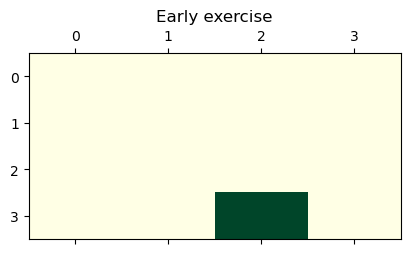

In [6]:
price=BM_Amer(S0=100, K=100, r=0.06, u=1.1, d=0.9091, T=1, Ntree=3, optype='put',exmat=True)
print(np.around(price,3))

In [9]:
# European and American option price comparison
price=BM_Euro(S0=100, K=100, r=0.06, u=1.1, d=0.9091, T=1, Ntree=3, optype='put')
print('European put price')
print(np.around(price,3))

price=BM_Amer(S0=100, K=100, r=0.06, u=1.1, d=0.9091, T=1, Ntree=3, optype='put')
print('American put price')
print(np.around(price,3))

European put price
[[ 0.     0.     0.    -0.   ]
 [ 0.     0.    -0.    -0.   ]
 [ 0.     1.526  3.724  9.089]
 [ 4.322  8.424 15.374 24.866]]
American put price
[[ 0.     0.     0.    -0.   ]
 [ 0.     0.    -0.    -0.   ]
 [ 0.     1.526  3.724  9.089]
 [ 4.654  9.235 17.354 24.866]]
